In [1]:
import spacy
from nltk.corpus import stopwords
import gensim
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import pickle
import spacy.cli
from nltk.stem import WordNetLemmatizer

spacy.cli.download("en_core_web_lg")
nltk.download('punkt')  # Download the Punkt tokenizer models
nltk.download('stopwords')
nltk.download('wordnet')

df= pd.read_csv("cleaned_dataset_10k.csv")

stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_lg')

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    def remove_stopwords(text):
        return [word for word in text if word not in stop_words]

    def lemmatize(text):
        return [lemmatizer.lemmatize(word) for word in text]


    tokenized_text = gensim.utils.simple_preprocess(text, deacc=True)
    no_stopwords = remove_stopwords(tokenized_text)
    lemmatized = lemmatize(no_stopwords)
    return lemmatized

def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_filtered = df[df['full_text'].notna()]
df_filtered.reset_index(drop=True, inplace=True)
print("data loaded")
df_filtered.head()

data loaded


,id,title,doi,categories,unique_primary_category,full_text
0,hep-ph/0610334,Weak interaction corrections to hadronic top q...,10.1103/PhysRevD.74.113005,hep-ph,hep-ph,arXiv:hep-ph/0610334v2 30 Nov 2006\nPITHA 06/...
1,2104.06416,Next-to-leading non-global logarithms in QCD,NaN,hep-ph,hep-ph,"Prepared for submission to JHEP\nOUTP-21-08P, ..."
2,hep-ph/9606269,$K_L \to \pi^o \nu \overline{\nu}$ in Extended...,10.1103/PhysRevD.54.4393,hep-ph,hep-ph,arXiv:hep-ph/9606269v3 27 Jun 1996\nWM-96-105...
3,hep-ph/9811382,A critical phenomenological study of inclusive...,10.1007/s100529900018,hep-ph,hep-ph,arXiv:hep-ph/9811382v1 18 Nov 1998\nA CRITICA...
4,1304.2781,Progress in the NNPDF global analysis,NaN,hep-ph,hep-ph,arXiv:1304.2781v1 [hep-ph] 9 Apr 2013\nEdinb...


In [3]:

# Filtering out texts with less than 8 sentences
filtered_df = df_filtered[df_filtered['full_text'].apply(count_sentences) >= 8]


del df

In [4]:
from dask.distributed import Client

client = Client(n_workers=24)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 48,Total memory: 63.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52803,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 63.76 GiB
Comm: tcp://127.0.0.1:52944,Total threads: 2
Dashboard: http://127.0.0.1:52951/status,Memory: 2.66 GiB
Nanny: tcp://127.0.0.1:52806,


In [6]:
import dask.dataframe as dd
import pandas as pd
from dask.multiprocessing import get
from dask import delayed, compute

# Assuming other imports and functions from the previous code snippet are already here.

# Convert the filtered pandas dataframe to a dask dataframe with partitions
# You can adjust the number of partitions as per your system's memory and CPU capabilities
dask_df = dd.from_pandas(filtered_df, npartitions=10)

# Applying the preprocess function to each partition
# Dask's map_partitions will apply the delayed_preprocess to each partition
result = dask_df['full_text'].map_partitions(lambda df: df.apply(lambda x: preprocess(x)), meta='object')

# Now, compute the result
# This step will trigger the parallel computation
results = result.compute(scheduler='processes')

# Assign the results to a new column in the original dataframe
filtered_df['processed_text'] = results

# To save this dataframe, you can use to_csv, to_parquet or any suitable format.
filtered_df.to_parquet('processed_arxiv_papers.parquet', index=False)



c:\Users\chris\AppData\Local\anaconda3\envs\gensim\lib\site-packages\dask\dataframe\core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
c:\Users\chris\AppData\Local\anaconda3\envs\gensim\lib\site-packages\dask\base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
C:\Users\chris\AppData\Local\Temp\ipykernel_18568\1571755314.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['processed_text'] = results
c:\

In [7]:
filtered_df["processed_text"].head(5)

0    [arxiv, hep, ph, nov, pitha, sdu, hep, weak, i...
1    [prepared, submission, jhep, outp, cern, th, n...
2    [arxiv, hep, ph, jun, wm, may, kl, πoνν, exten...
3    [arxiv, hep, ph, nov, critical, study, inclusi...
4    [arxiv, hep, ph, apr, edinburgh, progress, nnp...
Name: processed_text, dtype: object

In [1]:
import pandas as pd
df= pd.read_parquet("processed_arxiv_papers.parquet")
df.head(5)

,id,title,doi,categories,unique_primary_category,full_text,processed_text
0,hep-ph/0610334,Weak interaction corrections to hadronic top q...,10.1103/PhysRevD.74.113005,hep-ph,hep-ph,arXiv:hep-ph/0610334v2 30 Nov 2006\nPITHA 06/...,"[arxiv, hep, ph, nov, pitha, sdu, hep, weak, i..."
1,2104.06416,Next-to-leading non-global logarithms in QCD,None,hep-ph,hep-ph,"Prepared for submission to JHEP\nOUTP-21-08P, ...","[prepared, submission, jhep, outp, cern, th, n..."
2,hep-ph/9606269,$K_L \to \pi^o \nu \overline{\nu}$ in Extended...,10.1103/PhysRevD.54.4393,hep-ph,hep-ph,arXiv:hep-ph/9606269v3 27 Jun 1996\nWM-96-105...,"[arxiv, hep, ph, jun, wm, may, kl, πoνν, exten..."
3,hep-ph/9811382,A critical phenomenological study of inclusive...,10.1007/s100529900018,hep-ph,hep-ph,arXiv:hep-ph/9811382v1 18 Nov 1998\nA CRITICA...,"[arxiv, hep, ph, nov, critical, study, inclusi..."
4,1304.2781,Progress in the NNPDF global analysis,None,hep-ph,hep-ph,arXiv:1304.2781v1 [hep-ph] 9 Apr 2013\nEdinb...,"[arxiv, hep, ph, apr, edinburgh, progress, nnp..."


In [2]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

data_lemmatized = df["processed_text"]
# data_lemmatized.head(2)



# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

import csv
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm

def optimize_lda(corpus, id2word, data_lemmatized, topics_range, passes, output_csv):
    best_model = None
    best_coherence = float('-inf')
    results = []

    print("Starting LDA optimization over topics range...")

    for num_topics in tqdm(topics_range, desc='Optimizing LDA'):
        # Create an LDA model
        print(f"\nTraining LDA model with {num_topics} topics...")
        lda_model = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=num_topics,
                             passes=passes,alpha='auto',eta="auto")

        # Compute perplexity
        perplexity = lda_model.log_perplexity(corpus)
        print(f"Computed perplexity for {num_topics} topics: {perplexity:.4f}")

        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence = coherence_model.get_coherence()
        print(f"Computed coherence for {num_topics} topics: {coherence:.4f}")

        # Update results
        results.append({
            'num_topics': num_topics,
            'perplexity': perplexity,
            'coherence': coherence
        })

        # Save the model if it has the best coherence so far
        if coherence > best_coherence:
            best_coherence = coherence
            best_model = lda_model
            print("New best model found and saved with coherence:", best_coherence)

    # Write results to a CSV file
    print("\nSaving results to CSV...")
    with open(output_csv, 'w', newline='') as csvfile:
        fieldnames = ['num_topics', 'perplexity', 'coherence']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for result in results:
            writer.writerow(result)
    
    print(f"Results saved to {output_csv}")

    # Save the best model to disk
    best_model.save('best_lda_model_arxiv')
    print("Best LDA model saved to disk.")

    return results, best_model

# Example usage:
results, best_lda_model = optimize_lda(corpus=corpus, id2word=id2word, data_lemmatized=data_lemmatized, 
                                       topics_range=range(10, 20, 1), passes=20, 
                                       output_csv='lda_optimization_results_arxiv.csv')



[[(0, 5), (1, 2), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 2), (8, 18), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 9), (20, 1), (21, 1), (22, 2), (23, 2), (24, 6), (25, 2), (26, 5), (27, 26), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 3), (34, 5), (35, 5), (36, 2), (37, 2), (38, 5), (39, 1), (40, 4), (41, 4), (42, 2), (43, 2), (44, 3), (45, 2), (46, 1), (47, 2), (48, 1), (49, 3), (50, 1), (51, 4), (52, 1), (53, 2), (54, 1), (55, 1), (56, 2), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 13), (64, 1), (65, 1), (66, 1), (67, 4), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 4), (74, 42), (75, 4), (76, 1), (77, 2), (78, 3), (79, 1), (80, 56), (81, 5), (82, 11), (83, 3), (84, 6), (85, 2), (86, 3), (87, 1), (88, 2), (89, 2), (90, 13), (91, 1), (92, 5), (93, 2), (94, 1), (95, 3), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 11), (102, 1), (103, 3), (104, 3), (105, 1), (106, 1), (107, 1), (108, 10), (109, 1),

Optimizing LDA:   0%|          | 0/10 [00:00<?, ?it/s]


Training LDA model with 10 topics...
Computed perplexity for 10 topics: -9.0590


Optimizing LDA:  10%|█         | 1/10 [28:24<4:15:42, 1704.71s/it]

Computed coherence for 10 topics: 0.4631
New best model found and saved with coherence: 0.4630783916964405

Training LDA model with 11 topics...
Computed perplexity for 11 topics: -9.1519


Optimizing LDA:  20%|██        | 2/10 [56:06<3:43:55, 1679.46s/it]

Computed coherence for 11 topics: 0.4594

Training LDA model with 12 topics...
Computed perplexity for 12 topics: -9.2119


Optimizing LDA:  30%|███       | 3/10 [1:43:15<4:17:09, 2204.20s/it]

Computed coherence for 12 topics: 0.4734
New best model found and saved with coherence: 0.4734425155383666

Training LDA model with 13 topics...
Computed perplexity for 13 topics: -9.2861


Optimizing LDA:  40%|████      | 4/10 [4:18:30<8:21:10, 5011.67s/it]

Computed coherence for 13 topics: 0.4954
New best model found and saved with coherence: 0.4953810700709599

Training LDA model with 14 topics...
Computed perplexity for 14 topics: -9.3345


Optimizing LDA:  50%|█████     | 5/10 [4:53:36<5:30:19, 3963.86s/it]

Computed coherence for 14 topics: 0.4806

Training LDA model with 15 topics...
Computed perplexity for 15 topics: -9.3897


Optimizing LDA:  60%|██████    | 6/10 [5:26:28<3:39:05, 3286.43s/it]

Computed coherence for 15 topics: 0.4925

Training LDA model with 16 topics...
Computed perplexity for 16 topics: -9.4413


Optimizing LDA:  70%|███████   | 7/10 [6:02:13<2:25:40, 2913.53s/it]

Computed coherence for 16 topics: 0.4944

Training LDA model with 17 topics...
Computed perplexity for 17 topics: -9.5045


Optimizing LDA:  80%|████████  | 8/10 [6:39:43<1:30:04, 2702.12s/it]

Computed coherence for 17 topics: 0.4903

Training LDA model with 18 topics...
Computed perplexity for 18 topics: -9.5674


Optimizing LDA:  90%|█████████ | 9/10 [7:18:30<43:05, 2585.04s/it]  

Computed coherence for 18 topics: 0.4645

Training LDA model with 19 topics...
Computed perplexity for 19 topics: -9.6146


Optimizing LDA: 100%|██████████| 10/10 [7:59:52<00:00, 2879.22s/it]

Computed coherence for 19 topics: 0.4902

Saving results to CSV...
Results saved to lda_optimization_results_arxiv.csv
Best LDA model saved to disk.


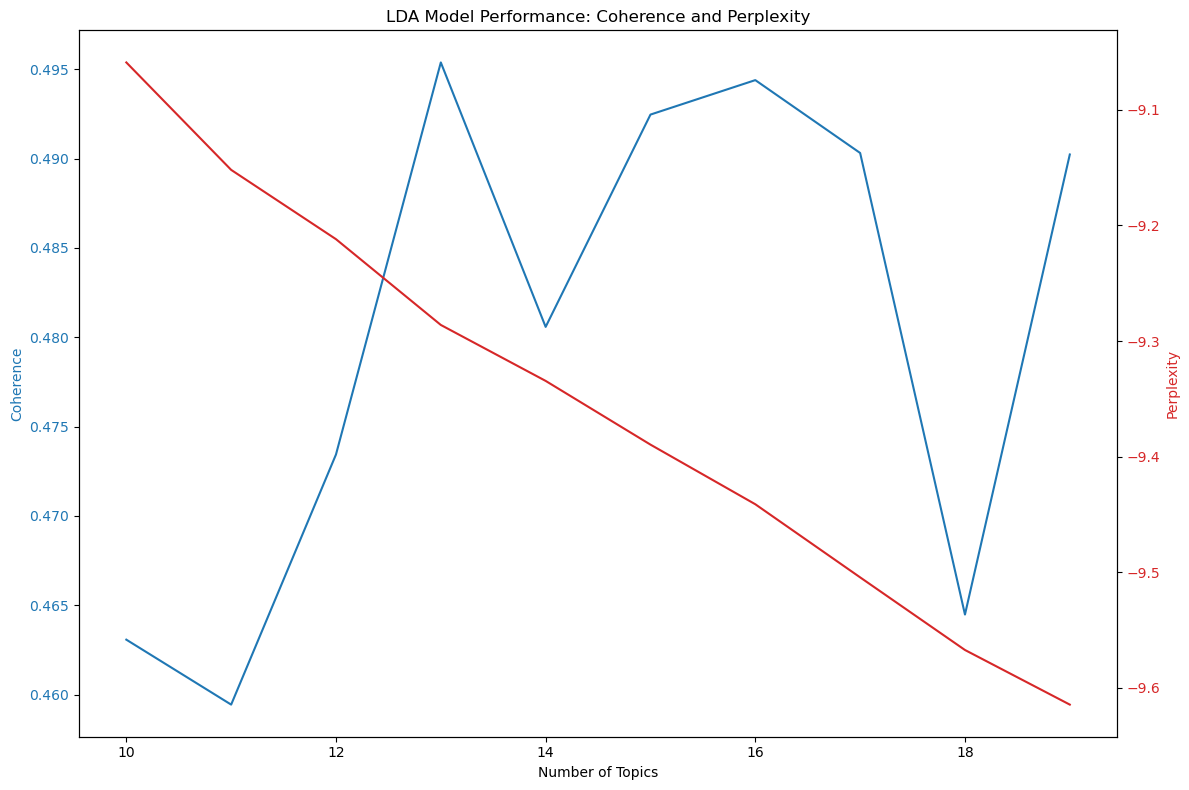

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('lda_optimization_results_arxiv.csv')

# Plotting the coherence and perplexity scores as a function of the number of topics
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot coherence
color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=color)
ax1.plot(df['num_topics'], df['coherence'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# Plot perplexity on the same graph but with a different y-axis
color = 'tab:red'
ax2.set_ylabel('Perplexity', color=color)
ax2.plot(df['num_topics'], df['perplexity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('LDA Model Performance: Coherence and Perplexity')
fig.tight_layout()  # to ensure the right y-label is not slightly clipped
plt.show()


In [5]:
import gensim
import numpy as np
from gensim.models.ldamulticore import LdaMulticore
import pandas as pd
import numpy as np
import gensim
from gensim.matutils import cossim
import random
import gensim.corpora as corpora
from gensim.corpora import Dictionary

df= pd.read_parquet("processed_arxiv_papers.parquet")
data_lemmatized = df["processed_text"]


# # Load id2word
# id2word = Dictionary.load('lda.model.id2word')


# # Create Corpus if it doesnt exist
# texts = data_lemmatized  
# # Term Document Frequency 
# corpus = [id2word.doc2bow(text) for text in texts]  
# corpora.MmCorpus.serialize('corpus.mm', corpus)



# corpus = corpora.MmCorpus('corpus.mm')
# lda_model = LdaMulticore.load('best_lda_model')

topic_distributions = best_lda_model.get_document_topics(corpus, minimum_probability=0)
df["lda_vector"]=topic_distributions

In [6]:
df.head()

,id,title,doi,categories,unique_primary_category,full_text,processed_text,lda_vector
0,hep-ph/0610334,Weak interaction corrections to hadronic top q...,10.1103/PhysRevD.74.113005,hep-ph,hep-ph,arXiv:hep-ph/0610334v2 30 Nov 2006\nPITHA 06/...,"[arxiv, hep, ph, nov, pitha, sdu, hep, weak, i...","[(0, 1.495732e-05), (1, 1.6804786e-05), (2, 2...."
1,2104.06416,Next-to-leading non-global logarithms in QCD,None,hep-ph,hep-ph,"Prepared for submission to JHEP\nOUTP-21-08P, ...","[prepared, submission, jhep, outp, cern, th, n...","[(0, 1.2148513e-05), (1, 0.0003325958), (2, 1...."
2,hep-ph/9606269,$K_L \to \pi^o \nu \overline{\nu}$ in Extended...,10.1103/PhysRevD.54.4393,hep-ph,hep-ph,arXiv:hep-ph/9606269v3 27 Jun 1996\nWM-96-105...,"[arxiv, hep, ph, jun, wm, may, kl, πoνν, exten...","[(0, 3.513029e-05), (1, 3.9471724e-05), (2, 5...."
3,hep-ph/9811382,A critical phenomenological study of inclusive...,10.1007/s100529900018,hep-ph,hep-ph,arXiv:hep-ph/9811382v1 18 Nov 1998\nA CRITICA...,"[arxiv, hep, ph, nov, critical, study, inclusi...","[(0, 1.870386e-05), (1, 2.1014082e-05), (2, 2...."
4,1304.2781,Progress in the NNPDF global analysis,None,hep-ph,hep-ph,arXiv:1304.2781v1 [hep-ph] 9 Apr 2013\nEdinb...,"[arxiv, hep, ph, apr, edinburgh, progress, nnp...","[(0, 7.238379e-05), (1, 8.1325365e-05), (2, 0...."


In [7]:
df2= pd.read_pickle("augmented_dataArxiv.pkl")
df2.head(2)

,id,embedding,medoids,cluster_sizes
0,hep-ph/0610334,"[[-0.09863124, -0.025400802, -0.005175168, 0.0...","[[-0.113838255, -0.013086513, -0.026049882, 0....","[55, 19, 55, 8]"
1,2104.06416,"[[-0.084981225, -0.08507558, 0.03543399, 0.086...","[[-0.13890694, -0.045757502, 0.0331088, 0.0221...","[61, 49, 40, 28]"


In [8]:
# Perform inner join on 'id' column
merged_df = pd.merge(df, df2[['id']], on='id', how='inner')
len(merged_df.index)
merged_df.to_pickle("merged_df_lda.pkl")

In [1]:
import numpy as np
import random
from gensim.matutils import cossim
import pandas as pd
merged_df= pd.read_pickle("merged_df_lda.pkl")

def sample_triplets(df, num_samples=1000, pos_threshold=0.6, neg_threshold=0.3, required_matches=10):
    # Initialize lists to collect positive and negative indices
    positive_indices = []
    negative_indices = []
    
    # Keep sampling until we have enough positives and negatives
    while len(positive_indices) < required_matches or len(negative_indices) < required_matches:
        anchor_idx = random.randint(0, len(df) - 1)
        anchor_id = df.iloc[anchor_idx]['id']
        anchor_vec = df.iloc[anchor_idx]['lda_vector']

        df_remaining = df.drop(anchor_idx).reset_index(drop=True)
        sampled_indices = np.random.choice(df_remaining.index, size=num_samples, replace=False)

        for idx in sampled_indices:
            similarity = cossim(anchor_vec, df_remaining.iloc[idx]['lda_vector'])

            # Add index to positives or negatives if it meets the threshold criteria
            if similarity > pos_threshold and len(positive_indices) < required_matches:
                positive_indices.append((idx, similarity))
            elif similarity < neg_threshold and len(negative_indices) < required_matches:
                negative_indices.append((idx, similarity))

        # Optionally print progress
        #print(f"Collected positives: {len(positive_indices)}, negatives: {len(negative_indices)}")

    # Randomly select one positive and one negative from the collected samples
    positive_idx = random.choice(positive_indices)[0]
    negative_idx = random.choice(negative_indices)[0]

    # Get the IDs for the positive and negative documents
    positive_id = df_remaining.iloc[positive_idx]['id']
    negative_id = df_remaining.iloc[negative_idx]['id']
    
    return anchor_id, positive_id, negative_id

# Assuming merged_df is your dataframe with lda_vectors
# Example usage
triplet = sample_triplets(merged_df)
print(triplet)


('astro-ph/9709029', '1810.06383', '2004.10018')


In [2]:
# Retrieve the document details based on the triplet IDs
def retrieve_documents(df, triplet):
    anchor_id, positive_id, negative_id = triplet
    
    # Retrieve the rows for the anchor, positive, and negative documents
    anchor_doc = df.loc[df['id'] == anchor_id]
    positive_doc = df.loc[df['id'] == positive_id]
    negative_doc = df.loc[df['id'] == negative_id]
    
    return anchor_doc, positive_doc, negative_doc

# Get the documents for the triplet
anchor_doc, positive_doc, negative_doc = retrieve_documents(merged_df, triplet)

# Display the document details
print("Anchor Document:\n", anchor_doc)
print("\nPositive Document:\n", positive_doc)
print("\nNegative Document:\n", negative_doc)



Anchor Document:
                    id                                              title  \
564  astro-ph/9709029  Evidence for GeV emission from the Galactic Ce...   

                 doi categories unique_primary_category  \
564  10.1063/1.54172   astro-ph                astro-ph   

                                             full_text  \
564  arXiv:astro-ph/9709029v1  3 Sep 1997\nEvidence...   

                                        processed_text  \
564  [arxiv, astro, ph, sep, evidence, gev, emissio...   

                                            lda_vector  
564  [(0, 8.5902015e-05), (1, 0.05555008), (2, 0.03...  

Positive Document:
              id                                              title  \
409  1810.06383  Electromagnetic perturbations of black holes i...   

                            doi categories unique_primary_category  \
409  10.1103/PhysRevD.98.085021      gr-qc                   gr-qc   

                                             full_text  \
4

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to run sampling in parallel
def run_sampling_in_parallel(df, num_triplets, pos_threshold, neg_threshold, num_threads):
    # Function to execute in each thread
    def thread_function(df):
        return sample_triplets(df,1000,pos_threshold,neg_threshold)

    triplets = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Schedule the callable 'thread_function' to be executed 'num_triplets' times
        future_to_triplet = {executor.submit(thread_function, df): i for i in range(num_triplets)}
        
        for future in as_completed(future_to_triplet):
            try:
                # Get the result from the future
                triplet = future.result()
                triplets.append(triplet)
            except Exception as exc:
                print(f'Generated an exception: {exc}')

    return triplets


# num_triplets = 30000
# num_threads = 10
# triplets = run_sampling_in_parallel(merged_df, num_triplets, num_threads)

# Concatenating the results - in this case, 'triplets' is already a list of results
# If you need to concatenate data from each thread, you could modify the list accordingly
# print("Created Triplets")


In [4]:

import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

# Assume cossim function and other necessary imports are already defined.



    # Your run_sampling_in_parallel code modified to pass the thresholds...

def run_sampling_multiple_times(df, sampling_parameters, num_threads):
    all_triplets = []  # This will hold all the triplets from each run

    for params in sampling_parameters:
        num_triplets = params['num_triplets']
        pos_threshold = params['pos_threshold']
        neg_threshold = params['neg_threshold']

        print(f"Running sampling with {num_triplets} triplets, positive threshold {pos_threshold}, and negative threshold {neg_threshold}")
        triplets = run_sampling_in_parallel(df, num_triplets, pos_threshold, neg_threshold, num_threads)
        
        # Add the triplets from this run to the overall list
        all_triplets.extend(triplets)

    return all_triplets

# Define your sampling parameters as a list of dictionaries before running the function
sampling_parameters = [
    {'num_triplets': 10000, 'pos_threshold': 0.6, 'neg_threshold': 0.4},
    {'num_triplets': 10000, 'pos_threshold': 0.6, 'neg_threshold': 0.4}
]

num_threads = 10  # Or whatever number of threads you want to use
all_results = run_sampling_multiple_times(merged_df, sampling_parameters, num_threads)

# Now all_results will contain all the triplets sampled for each run with the respective parameters


Running sampling with 10000 triplets, positive threshold 0.6, and negative threshold 0.4
Running sampling with 10000 triplets, positive threshold 0.6, and negative threshold 0.4


In [7]:
import pickle
with open('Arxiv_tripletIds.pickle', 'wb') as f:
    pickle.dump(all_results, f)

print(f"Saved {len(all_results)} triplets to 'Arxiv_tripletIds.pickle'")

Saved 20000 triplets to 'Arxiv_tripletIds.pickle'
